In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import glob, os

os.chdir('../core')
import stitching_ssid as ssid

os.chdir('../../../../pyRRHDLDS/core')
import ssm_scripts

import pprint

# Generate LTI system

$ y_t = C x_t + D u_t $  

$ x_{t+1} = A x_t + B u_t $

$ y_t \in \mathbb{R}^p, x_t \in \mathbb{R}^n ,u_t \in \mathbb{R}^m, t \in \{0, \ldots, T \}  $ 


 Chosen system and simulation sizes: 
 (p, n, m, T) =  (4, 3, 2, 100)

 Generated input, output and state trajectories:


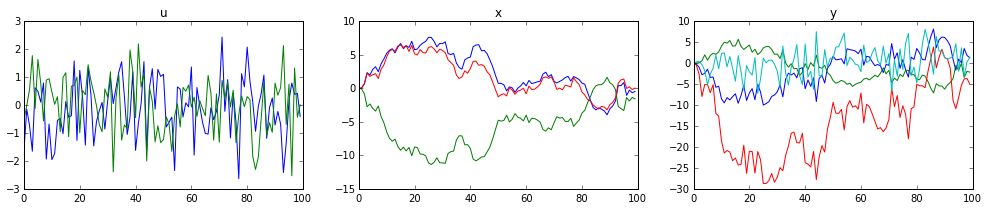

In [2]:
p, n, m, T = 4, 3, 2, 100

print('\n Chosen system and simulation sizes: ')
print(' (p, n, m, T) = ', (p, n, m, T))

pars_true, options = ssm_scripts.gen_pars(x_dim=n, y_dim=p, u_dim=m, pars_in=None, obs_scheme=None, 
                                 gen_A='full', lts=np.linspace(0.95, 0.99, n), gen_B='random', gen_Q='identity', 
                                 gen_mu0='zero', gen_d='zero', gen_R='zero', diag_R_flag=True)
pars_true['D'] = np.random.normal(size=(p,m))

# Return function sim_sys() that returns output given inputs
sim_sys = ssid.d_system(pars_true, stype='LTI')

# Fix input signal (given system matrices, will fix the output!)
inputs = np.random.normal(0,1,size=(T,m))

# Compute x, y
data, stateseq = sim_sys(inputs)

# Visualize    
print('\n Generated input, output and state trajectories:')
plt.figure(figsize=(17,3))
plt.subplot(1,3,3)
plt.plot(data)
plt.title('y')
plt.subplot(1,3,2)
plt.plot(stateseq)
plt.title('x')
plt.subplot(1,3,1)
plt.plot(inputs)
plt.title('u')
plt.show()

# Ho-Kalman's method 

Ho-Kalman reconstructs the system matrices $A,B,C,D$ from the impulse responses $G_t$ of the system.

We will use the true system matrices to simulate the impulse reponses $G_t$, as the system ouput $y_t$ of a system at rest ($x_0 = 0$) upon stimulation with an impulse at $t=0$, i.e. $u_0 = 1, u_t = 0$ for $t>0$.

- ground truth input response functions (using ground-truth $A,B,C,D$), 
- system initially at rest x_0 = 0
- impulse responses of length $k+l \geq 2n$ are sufficient
- latent dimensionality $\hat{n}$ is estimated from the (Hankel matrix of) impulse responses
- $(A,B,C)$ has to be minimal for this to work, i.e. $(A,C)$ being observable, $(B,C)$ being reachable
- there is two ways to get $A$ (reachability or observability matrix), both are implemented



true and estimated latent dim. : (n, n_hat) =  (3, 3)

 We check system identification quality by comparing true and estimated outputs to *novel* inputs 
 
worst-cell reconstruction MSE =  4.60950622125e-26
average reconstruction MSE =  1.7897039459e-26


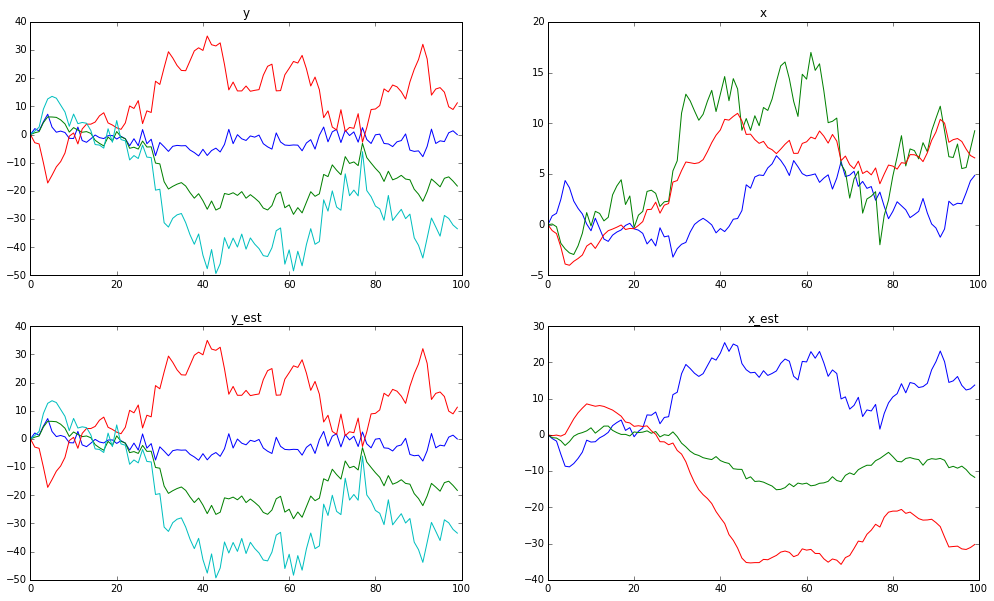

In [8]:
# set-up 
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least ground-truth n
G_true = ssid.d_calc_impulse_responses(pars_true)
comp_A_from = 'observability' # can get A either from observability or from reachability matrix

# Do Ho-Kalman
pars_est, obs_est , reach_est , _ , n_est = ssid.Ho_Kalman(G_true,k,l,comp_A_from)
pars_est['mu0'] = np.zeros(n)

# Since there is no noise, we can just check system identification by feeding novel inputs into the true and
# our reconstructed system - the outputs should be identical (note this depends on knowing that x(0)=0)
inputs = np.random.normal(0,1,size=(T,m))
data, stateseq = sim_sys(inputs)
data_est, stateseq_est = ssid.d_sim_system_LTI(pars_est, inputs)
print('')
print('true and estimated latent dim. : (n, n_hat) = ', (n, n_est))

err = ssid.data_reconstruction_MSE(data, data_est)
print('\n We check system identification quality by comparing true and estimated outputs to *novel* inputs \n ')
print('worst-cell reconstruction MSE = ', err.max())
print('average reconstruction MSE = ', err.mean())

# Visualize    
plt.figure(figsize=(17,10))
plt.subplot(2,2,1)
plt.plot(data)
plt.title('y')
plt.subplot(2,2,3)
plt.plot(data_est)
plt.title('y_est')
plt.subplot(2,2,2)
plt.plot(stateseq)
plt.title('x')
plt.subplot(2,2,4)
plt.plot(stateseq_est)
plt.title('x_est')
plt.show()

# naive Ho-Kalman's method on systems not at rest

- imulse input $$ u_t =
\left\{
	\begin{array}{ll}
		1 & \mbox{if } t = 0 \\
		0   & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses from output data of system
- assuming $x_0 =0$ even though the system initially is **not** at rest


In [9]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
Gs, X0 = ssid.d_est_input_responses(pars_true,k+l,0)
pars_est, obs_est , reach_est , _ , n_est = ssid.Ho_Kalman(Gs[0:],k,l,comp_A_from)

print('\n Applying Ho-Kalman to improper impulse responses of the ground-truth system')
print('(improper means that x(0)~=0, so that the impulse responses superimpose with CA^{t-1}x(0))')

print('\n The estimated parameters B,D will be wrong, but we can correct using the ground-truth x(0)')

print('\n true and estimated D \n')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B \n')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B \n')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))

print('\n true and estimated tilde{D} (correcting with true x(0)) \n ')
print(pars_true['D'] + pars_true['C'].dot(X0.T))
print('')
print(pars_est['D'])

print('\n true and estimated tilde{C}*tilde{B} (correcting with true x(0)) \n')
print(pars_true['C'].dot(pars_true['B']) + pars_true['C'].dot(pars_true['A'].dot(X0.T)))
print('')
print(pars_est['C'].dot(pars_est['B']))





 Applying Ho-Kalman to improper impulse responses of the ground-truth system
(improper means that x(0)~=0, so that the impulse responses superimpose with CA^{t-1}x(0))

 The estimated parameters B,D will be wrong, but we can correct using the ground-truth x(0)

 true and estimated D 

[[ 1.61617293  0.08364512]
 [ 0.30940126 -0.24177947]
 [-0.76713257 -0.93963086]
 [ 0.21453525 -1.79496304]]

[[  10.71835454    0.23968122]
 [  76.64110745    7.20149931]
 [ -65.68704801   -4.36380136]
 [ 143.90254554   12.77863911]]

 true and estimated C*B 

[[ 0.59121863 -0.63914635]
 [ 0.77204274 -2.00152832]
 [-2.62914019  3.30209422]
 [ 1.91676867 -2.75773559]]

[[  9.60231140e+00  -4.84609374e-01]
 [  7.67796803e+01   5.17472301e+00]
 [ -6.70661129e+01  -1.51598484e-02]
 [  1.44952057e+02   1.13185717e+01]]

 true and estimated C*A*B 

[[ 0.58533937 -0.63264984]
 [ 0.94617061 -2.10801648]
 [-2.67210308  3.31635544]
 [ 2.20750874 -2.97681525]]

[[  9.50625151e+00  -4.79596863e-01]
 [  7.66125947e+

# corrected Ho-Kalman's method on systems not at rest

- extended imulse input $$ u_t =
\left\{
	\begin{array}{ll}
        0 & \mbox{if } -n < t < 0 \\
		1 & \mbox{if } t = 0 \\
		0 & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses from output data of system
- using Ho-Kalman ill-assuming $x_0 =0$, then correcting the system matrix estimates


In [10]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
pars_est, sqs, n_est, X0_est = ssid.Ho_Kalman_nonzero_init(pars_true, k, l)

print('\n Applying Ho-Kalman to improper impulse responses of the ground-truth system')
print(' and correcting for this using observability and an extended (zero-padded) input sequence')
print('\n true and estimated D')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))



 Applying Ho-Kalman to improper impulse responses of the ground-truth system
 and correcting for this using observability and an extended (zero-padded) input sequence

 true and estimated D
[[ 1.61617293  0.08364512]
 [ 0.30940126 -0.24177947]
 [-0.76713257 -0.93963086]
 [ 0.21453525 -1.79496304]]

[[ 1.61617293  0.08364512]
 [ 0.30940126 -0.24177947]
 [-0.76713257 -0.93963086]
 [ 0.21453525 -1.79496304]]

 true and estimated C*B
[[ 0.59121863 -0.63914635]
 [ 0.77204274 -2.00152832]
 [-2.62914019  3.30209422]
 [ 1.91676867 -2.75773559]]

[[ 0.59121863 -0.63914635]
 [ 0.77204274 -2.00152832]
 [-2.62914019  3.30209422]
 [ 1.91676867 -2.75773559]]

 true and estimated C*A*B
[[ 0.58533937 -0.63264984]
 [ 0.94617061 -2.10801648]
 [-2.67210308  3.31635544]
 [ 2.20750874 -2.97681525]]

[[ 0.58533937 -0.63264984]
 [ 0.94617061 -2.10801648]
 [-2.67210308  3.31635544]
 [ 2.20750874 -2.97681525]]


# stitching Ho-Kalman for systems not at rest, stitching impulse responses

- extended imulse input $$ u_t =
\left\{
	\begin{array}{ll}
        0 & \mbox{if } -n < t < 0 \\
		1 & \mbox{if } t = 0 \\
		0 & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses $G^i_t$ individually for each subpopulation from output data of system
- using Ho-Kalman on each subpopulation, ill-assuming $x_0 =0$ and then correcting the system matrix estimates $(A^i, B^i, C^i, D^i)$
- stitching the subpopulations by stitching the impulse responses ($G^i_t \rightarrow G_t$) before applying Ho-Kalman once more (now for the whole system)


In [11]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
sub_pops = ((0,1), (1,2), (2,3))
method = 'impulses' # stitching using impulse responses
pars_est, n_est = ssid.stitching_Ho_Kalman(pars_true, sub_pops, k, method=method)

print('\n true and estimated D')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))


 true and estimated D
[[ 1.61617293  0.08364512]
 [ 0.30940126 -0.24177947]
 [-0.76713257 -0.93963086]
 [ 0.21453525 -1.79496304]]

[[ 1.61617293  0.08364512]
 [ 0.30940126 -0.24177947]
 [-0.76713257 -0.93963086]
 [ 0.21453525 -1.79496304]]

 true and estimated C*B
[[ 0.59121863 -0.63914635]
 [ 0.77204274 -2.00152832]
 [-2.62914019  3.30209422]
 [ 1.91676867 -2.75773559]]

[[ 0.59121863 -0.63914635]
 [ 0.77204274 -2.00152832]
 [-2.62914019  3.30209422]
 [ 1.91676867 -2.75773559]]

 true and estimated C*A*B
[[ 0.58533937 -0.63264984]
 [ 0.94617061 -2.10801648]
 [-2.67210308  3.31635544]
 [ 2.20750874 -2.97681525]]

[[ 0.58533937 -0.63264984]
 [ 0.94617061 -2.10801648]
 [-2.67210308  3.31635544]
 [ 2.20750874 -2.97681525]]


# stitching Ho-Kalman for systems not at rest, aligning system matrices

- extended imulse input $$ u_t =
\left\{
	\begin{array}{ll}
        0 & \mbox{if } -n < t < 0 \\
		1 & \mbox{if } t = 0 \\
		0 & \mbox{if } 0 < t < 2n
	\end{array}
\right.$$
- estimating input responses $G^i_t$ individually for each subpopulation from output data of system
- using Ho-Kalman on each subpopulation, ill-assuming $x_0 =0$ and then correcting the system matrix estimates $(A^i, B^i, C^i, D^i)$
- stitching the subpopulations by explictily rotating the obtained subpopulation system matrices $(A^i, B^i, C^i, D^i)$ using constraints obtained from observability matrices $\mathcal{O}_k$ and reachability matrices $\mathcal{C}_l$ under pairs of subpopulations $i \neq j$


In [12]:
k, l = n, n # algorithm is guaranteed to work (given assumptions are met) if k,l are at least n
sub_pops = (np.array((0,1)), np.array((1,2)), np.array((2,3)))

method = 'parameters_reach' # '_reach' to use reachability matrix, '_obs' for using observability matrix

pars_est, n_est = ssid.stitching_Ho_Kalman(pars_true, sub_pops, k, method=method)

print('\n true and estimated D')
print(pars_true['D'])
print('')
print(pars_est['D'])
print('\n true and estimated C*B')
print(pars_true['C'].dot(pars_true['B']))
print('')
print(pars_est['C'].dot(pars_est['B']))
print('\n true and estimated C*A*B')
print(pars_true['C'].dot(pars_true['A'].dot(pars_true['B'])))
print('')
print(pars_est['C'].dot(pars_est['A']).dot(pars_est['B']))



 true and estimated D
[[ 1.61617293  0.08364512]
 [ 0.30940126 -0.24177947]
 [-0.76713257 -0.93963086]
 [ 0.21453525 -1.79496304]]

[[ 1.61617293  0.08364512]
 [ 0.30940126 -0.24177947]
 [-0.76713257 -0.93963086]
 [ 0.21453525 -1.79496304]]

 true and estimated C*B
[[ 0.59121863 -0.63914635]
 [ 0.77204274 -2.00152832]
 [-2.62914019  3.30209422]
 [ 1.91676867 -2.75773559]]

[[ 0.59121863 -0.63914635]
 [ 0.77204274 -2.00152832]
 [-2.62914019  3.30209422]
 [ 1.91676867 -2.75773559]]

 true and estimated C*A*B
[[ 0.58533937 -0.63264984]
 [ 0.94617061 -2.10801648]
 [-2.67210308  3.31635544]
 [ 2.20750874 -2.97681525]]

[[ 0.58533937 -0.63264984]
 [ 0.94617061 -2.10801648]
 [-2.67210308  3.31635544]
 [ 2.20750874 -2.97681525]]


# New stuff (under construction)


 Chosen system and simulation sizes: 
 (p, n, m, T) =  (10, 3, 2, 150)
rank O:  3


/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


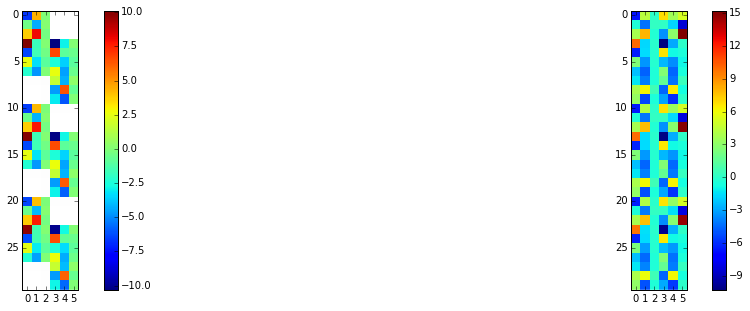

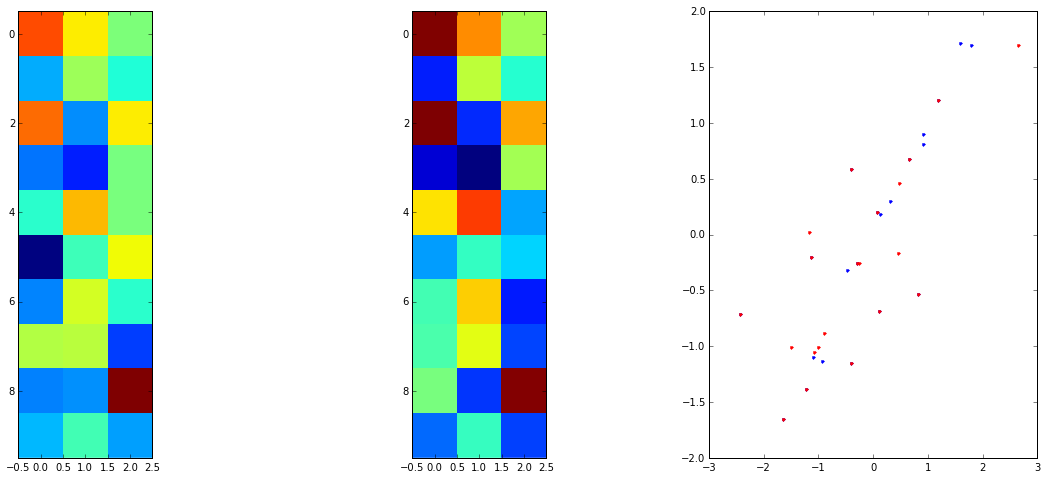

In [48]:
%matplotlib inline
from timeit import default_timer as timer


p, n, m, T = 10, 3, 2, 150

print('\n Chosen system and simulation sizes: ')
print(' (p, n, m, T) = ', (p, n, m, T))

pars_true, options = ssm_scripts.gen_pars(x_dim=n, y_dim=p, u_dim=m, pars_in=None, obs_scheme=None, 
                                 gen_A='full', lts=np.linspace(0.95, 0.99, n), gen_B='random', gen_Q='identity', 
                                 gen_mu0='zero', gen_d='zero', gen_R='zero', diag_R_flag=True)
pars_true['D'] = np.random.normal(size=(p,m))

print('rank O: ', np.linalg.matrix_rank( ssid.observability_mat(pars_true,n) ) )

# Return function sim_sys() that returns output given inputs
sim_sys = ssid.d_system(pars_true, stype='LTI')

# Fix input signal (given system matrices, will fix the output!)
inputs = np.random.normal(0,1,size=(T,m))

# Compute x, y
data, stateseq = sim_sys(inputs)


##############
# new stuff  #
##############

sub_pops = (np.arange(0,7), np.arange(3,10))
r = len(sub_pops)

k,l = n,n
comp_A_from='observability'
observ = np.zeros((k*p, r*n))
#L22 = np.nan * np.empty((k*p, k*sum([sub_pops[i].size for i in range(r)])))
L22 = np.nan * np.empty((k*p, r*n))
for i in range(r):
    data_i = data[:,sub_pops[i]]
    W_i = ssid.input_output_Hankel_mat(data_i, inputs, k, l, N=T-k-l+1)

    start = timer()
    L = np.linalg.qr(W_i, mode='r').T
    L22_i = L[k*m:,k*m:]
    end = timer()
    
    U,s,V = np.linalg.svd(L22_i)
    sqs = np.sqrt(s)
    n = np.sum(np.abs(sqs)>1e-3) # latent dimensionality determined from data!
    U, sqS, V = U[:,:n], np.diag(sqs[:n]), V[:n,:]
    L22_i = U.dot(sqS)    
    
    rho_k = np.hstack( [sub_pops[i]+kr*p for kr in range(k)] )
    #idx_n = k*sum([sub_pops[j].size for j in range(i)]) + np.arange(k*sub_pops[i].size,dtype=int)
    idx_n = np.arange(i*n, (i+1)*n)
    L22[np.ix_(rho_k, idx_n)] = L22_i.copy()

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(L22, interpolation='none')
plt.colorbar()
plt.subplot(1,2,2)
Z = ssid.soft_impute(L22, n, max_iter=5000)
plt.imshow(Z, interpolation='none')
plt.colorbar()

U,s,V = np.linalg.svd(Z)
sqs = np.sqrt(s)
n = np.sum(np.abs(sqs)>1e-3) # latent dimensionality determined from data!
U, sqS, V = U[:,:n], np.diag(sqs[:n]), V[:n,:]
observ = U.dot(sqS)

if comp_A_from == 'observability':
    A = ssid.comp_A(observ, p, k, comp_A_from)
if comp_A_from == 'reachability':
    A = ssid.comp_A(reach, m, l, comp_A_from)

pars_est = {'A' : A, 
            'B' : None,
            'C' : observ[:p,:n],
            'D' : None}

ssid.rotate_latent_bases_obs(np.arange(p), np.arange(p), pars_true, pars_est, overwrite=True)

plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.imshow(pars_true['C'], interpolation='none')
plt.subplot(1,3,2)
plt.imshow(pars_est['C'], interpolation='none')
plt.subplot(1,3,3)
plt.plot(pars_true['C'][sub_pops[0],:], pars_est['C'][sub_pops[0],:], 'b.')
plt.hold(True)
plt.plot(pars_true['C'][sub_pops[1],:], pars_est['C'][sub_pops[1],:], 'r.')
plt.show()            

    

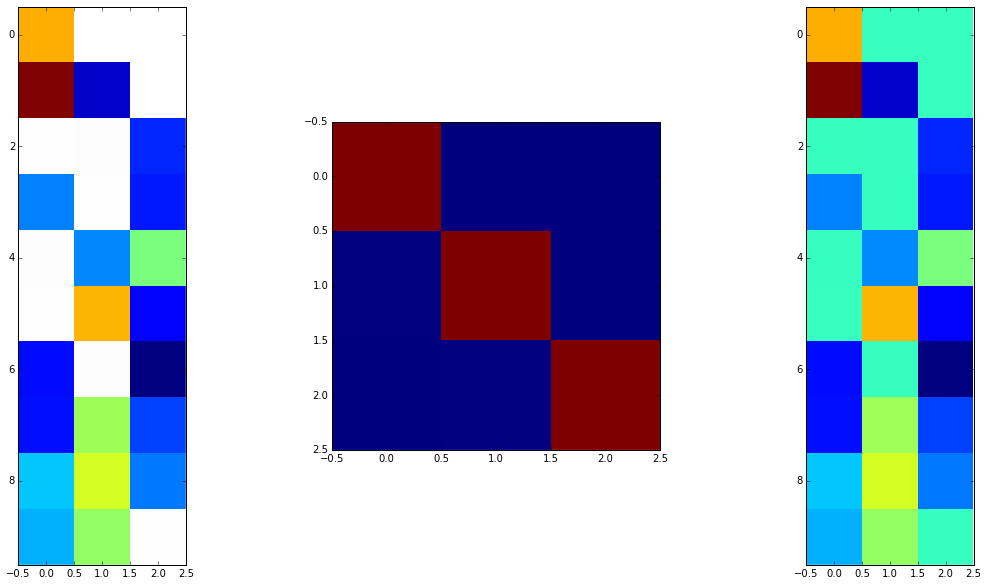

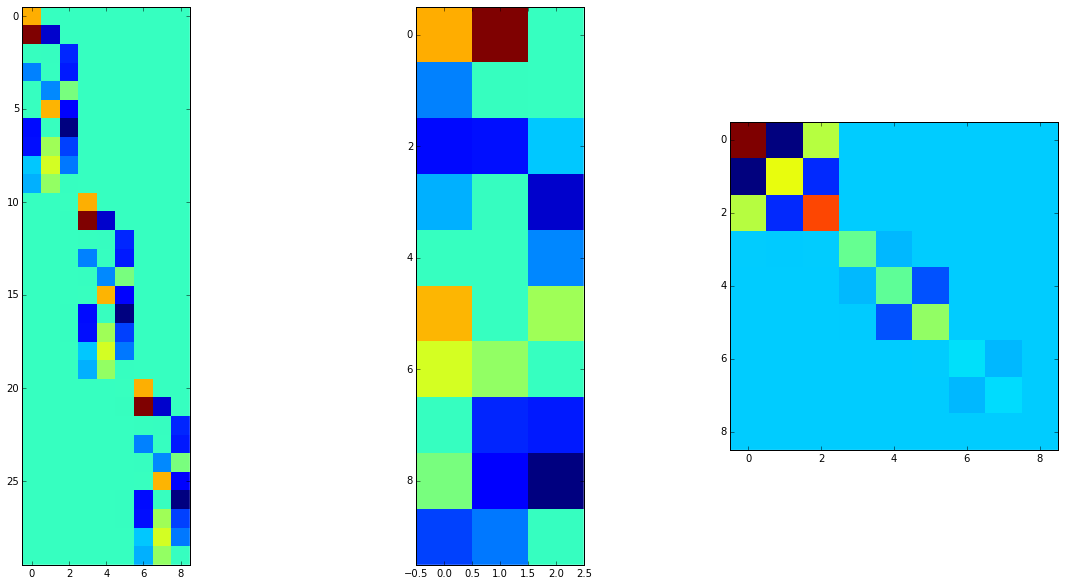

/home/mackelab/anaconda3/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


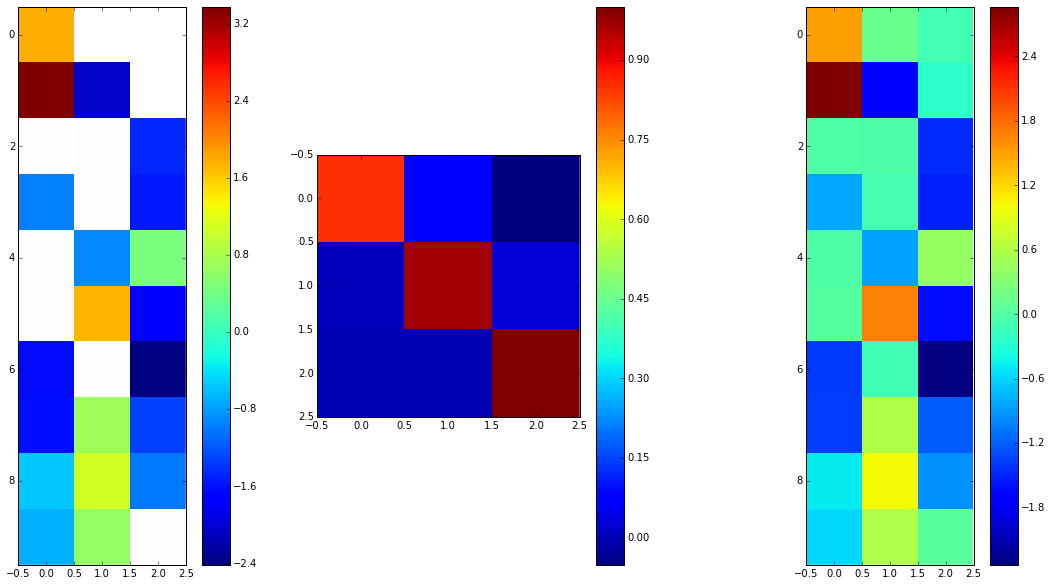

[ 0.12567127 -0.09123814 -0.11426259  0.00754751 -0.22919417  0.
 -0.06766349 -0.00391597  0.          0.05355878]
[[ 0.85089378  0.07026691 -0.05101422]
 [ 0.00434233  0.96655291  0.02814298]
 [ 0.          0.          1.        ]]


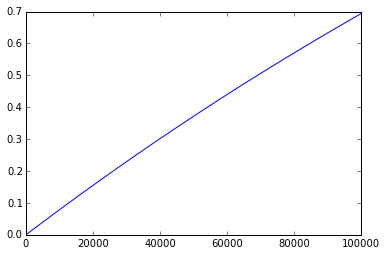

In [16]:
p,n = 10,3
O_true = np.random.normal(size=(p,n)).dot(np.random.normal(size=(n,n)))
O = O_true.copy()
O_nan = O_true.copy()

idx_zero =np.unravel_index(np.random.choice(O.size,O.size//3,False),O.shape)
idx_0 = np.sort(np.arange(p*n).reshape(p,n)[idx_zero])
O_nan[idx_zero] = np.nan
O[idx_zero] = 0

Minv = np.eye(n) #np.random.normal(size=(n,n))

OMinv = O.dot(Minv)


plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(O_nan, interpolation='none')
plt.subplot(1,3,2)
plt.imshow(Minv, interpolation='none')
plt.subplot(1,3,3)
plt.imshow(OMinv, interpolation='none')
plt.show()

#print(O)
#print(OMinv)

W, B, a = np.linalg.inv(Minv).reshape(n*n,1), np.kron(np.eye(n), OMinv) , 0.0000001

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(B, interpolation='none')
plt.subplot(1,3,2)
plt.imshow((B.dot(W)).reshape(p,n), interpolation='none')

B = B[idx_0, :]
BBT = B.T.dot(B)

plt.subplot(1,3,3)
plt.imshow(BBT, interpolation='none')

max_iter = 100000
perf = np.empty((max_iter,))
for t in range(max_iter):
    W -= a * BBT.dot(W)
    Orec = OMinv.dot(W.reshape(n,n))[idx_zero]
    perf[t] = np.abs(Orec).sum()
    
W = W.reshape(n,n)

Orec = OMinv.dot(W)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(O_nan, interpolation='none')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(W, interpolation='none')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(Orec, interpolation='none')
plt.colorbar()
plt.show()

print(Orec[idx_zero])
print(W.dot(Minv))

plt.figure()
plt.plot(perf)